
# Lab Two: Exploring Image Data

### Dataset: 
Ships in Satellite Imagery
https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
Group: Benjamin Kuo & Nick Benso

Note: download the data folder from the link then add it to the same folder as the notebook and rename the downloaded folder as data

## Business Understanding (2 points total).  
- [2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 




## Data Preparation (1 points total)
- [.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary. 
- [.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   
- [.1 points] Visualize several images.

In [143]:
from matplotlib import pyplot as plt
from skimage import color
from skimage import io
import numpy as np
import pandas as pd
import os

#image name format: {label} _ {scene id} _ {longitude} _ {latitude}.png
#label: 0-no ship(includes incomplete ships), 1-ship

root = r"data\\shipsnet\\shipsnet\\"
testfile = r"0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png"

def loadImg(dir, imgFile):
    img = io.imread(dir + imgFile)
    return color.rgb2gray(img)

def filenameParse(filename):
    repl_delim = '__'
    str = filename.replace(".png", repl_delim)
    return str.split('__')

In [144]:

#read in all images into np arrays
img = []
label = []
sceneID = []
long = []
lat = []

directory = os.fsencode(root)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    count = 0
    if(filename.endswith(".png")):
        img.append(loadImg(root, filename).flatten())
        parsed = filenameParse(filename)
        label.append(parsed[0])
        sceneID.append(parsed[1])
        long.append(parsed[2].split('_')[0])
        lat.append(parsed[2].split('_')[1])
        continue
    else:
        continue
        
print(type(img[0]))


<class 'numpy.ndarray'>


In [145]:
#load np arrays into a dataframe
d = {'data': img, 'label': label, 'sceneID': sceneID, 'longitude': long, 'latitude': lat}
df = pd.DataFrame(data=d)

df.label = df.label.astype(int).astype(bool)
df.longitude = df.longitude.astype(np.float64)
df.latitude = df.latitude.astype(np.float64)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data       4000 non-null   object 
 1   label      4000 non-null   bool   
 2   sceneID    4000 non-null   object 
 3   longitude  4000 non-null   float64
 4   latitude   4000 non-null   float64
dtypes: bool(1), float64(2), object(2)
memory usage: 129.0+ KB


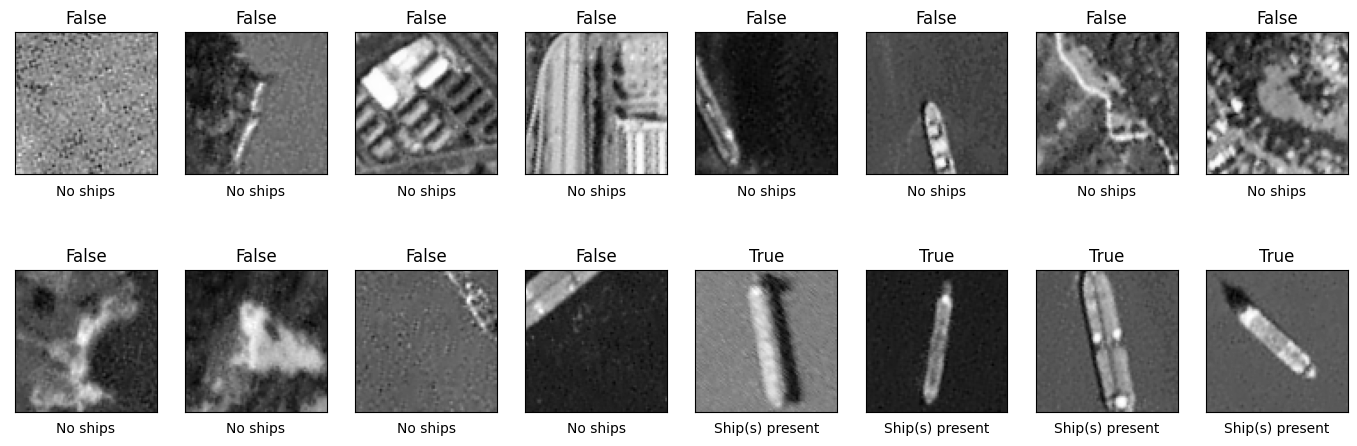

In [146]:
'''
plt.gray()
for i in range(0,4000,500):
    plt.figure()
    plt.imshow(df.data[i].reshape(80,80))
    print("Image",i," includes ", df.label[i], " ship(s)")
    #io.imshow(df.data[i].reshape(80,80))
    '''
    
def plot_gallery(images, titles, n_row=2, n_col=8):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i, index in enumerate(range(0,4000,4000//(n_row*n_col))):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[index].reshape(80,80), cmap=plt.cm.gray)
        plt.title(titles[index], size=12)
        plt.xticks(())
        plt.yticks(())
        if(titles[index] == 1):
            plt.xlabel("Ship(s) present")
        else:
            plt.xlabel("No ships")
        
plot_gallery(df.data, df.label)

## Data Reduction (6 points total)
- [.5 points] Perform linear dimensionality reduction of the images using **principal components analysis**. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
- [.5 points] Perform linear dimensionality reduction of your image data using **randomized principle components analysis**. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
- [2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?
- [1 points] Perform feature extraction upon the images using **DAISY**. Try different parameters for your image data.
- [2 points] Does this feature extraction method show promise for your prediction task? Why?
Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  

## Exceptional Work (1 points total)
- (0.4) The overall quality of the report as a coherent, useful, and polished product will be reflected here. Does it make sense overall? Do your visualizations answer the questions you put forth in your business analysis? Do you properly and consistently cite sources and annotate changes made to base code? Do you provide specific reasons for your assumptions? Do subsequent questions follow naturally from initial exploration?

In [148]:
from sklearn.decomposition import PCA

h = 80
w = 80
n_comp = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, df.data.shape[0]))

pca = PCA(n_components = n_comp)
X = img
%time pca.fit(X.copy())
eigenships = pca.components_.reshape((n_comp, h, w))

Extracting the top 300 eigenfaces from 4000 faces
CPU times: total: 9min 58s
Wall time: 3min 27s


In [151]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [152]:
plot_explained_variance(pca)

ModuleNotFoundError: No module named 'plotly'

In [ ]:
n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, df.data.shape[0]))

rpca = PCA(n_components=n_comp, svd_solver='randomized')
%time rpca.fit(X.copy())
eigenships = rpca.components_.reshape((n_comp, h, w))

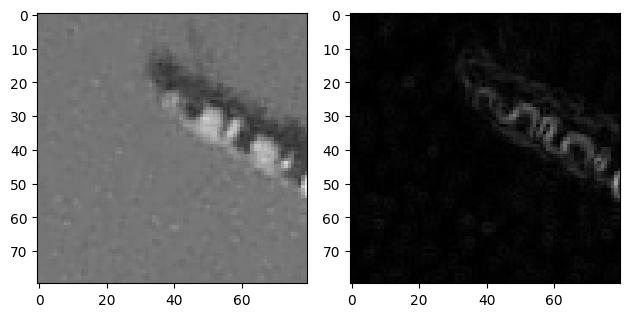

In [106]:
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v

plt.subplot(1,2,1)
idx_to_reconstruct = int(np.random.rand(1)*len(df.data))
img  = df.data[idx_to_reconstruct].reshape((h,w))
imshow(img)
plt.grid(False)


plt.subplot(1,2,2)
gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid(False)

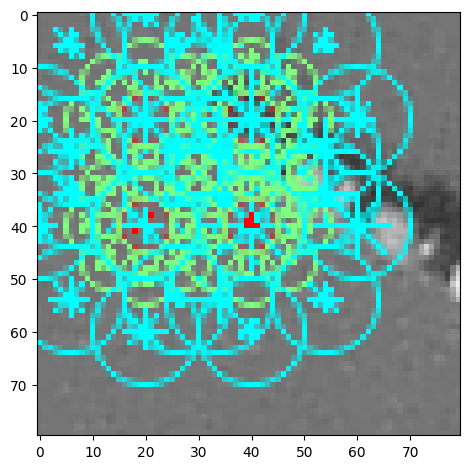

In [107]:
from skimage.feature import daisy

# lets first visualize what the daisy descriptor looks like
features, img_desc = daisy(img, 
                           step=20, 
                           radius=20, 
                           rings=2, 
                           histograms=8, 
                           orientations=8, 
                           visualize=True)
imshow(img_desc)
plt.grid(False)

In [129]:
features = daisy(img, step=20, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(2, 2, 68)
272


In [130]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=20, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(df.data[3],(h,w))
test_feature.shape

CPU times: total: 15.6 ms
Wall time: 14.6 ms


(272,)

In [137]:
%time daisy_features = np.apply_along_axis(apply_daisy, 1, df.data, (h,w))
print(daisy_features.shape)

AxisError: axis 1 is out of bounds for array of dimension 1

(272,)
